In [29]:
import json
from collections import defaultdict

import pandas as pd
import sqlalchemy
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from tqdm import tqdm

from fswe_demo.infra.db.get_conn import get_db_connection

## Load data


In [30]:
conn = get_db_connection()

In [31]:
# Get data from the db

transaction_df = pd.read_sql_table("int_product_baskets", conn)

In [32]:
transaction_df

,user_id,rated_date,transaction_id,product_basket,basket_size
0,AE22236AFRRSMQIKGG7TPTB75QEA,2015-03-17,AE22236AFRRSMQIKGG7TPTB75QEA_2015-03-17 00:00:00,"[B00M4I1BAY, B08QKWQS9J]",2
1,AE22A55GVSQJJKBIAZRBQHNTKPMQ,2016-01-23,AE22A55GVSQJJKBIAZRBQHNTKPMQ_2016-01-23 00:00:00,"[B006GWO5NE, B00QL1ZN3G]",2
2,AE22A55GVSQJJKBIAZRBQHNTKPMQ,2016-03-18,AE22A55GVSQJJKBIAZRBQHNTKPMQ_2016-03-18 00:00:00,"[B01FMOGIEK, B07WWGYJ8M]",2
3,AE22KJYRAAYX6LZUXXU72HYJRZNA,2016-02-13,AE22KJYRAAYX6LZUXXU72HYJRZNA_2016-02-13 00:00:00,"[B00JQTO8TU, B016MAOS5E, B07193SG3D, B0BK6SGHH...",5
4,AE22KJYRAAYX6LZUXXU72HYJRZNA,2016-08-11,AE22KJYRAAYX6LZUXXU72HYJRZNA_2016-08-11 00:00:00,"[B002DPUUL4, B09TWVB2TH]",2
...,...,...,...,...,...
20414,AHZZM7BCJAF2UEMMBHZCLXBB2SVA,2016-03-02,AHZZM7BCJAF2UEMMBHZCLXBB2SVA_2016-03-02 00:00:00,"[B01CL4CUI2, B0BVH24H94]",2
20415,AHZZNY4I7DJBEGVSPF4Z6L55G7LA,2015-01-03,AHZZNY4I7DJBEGVSPF4Z6L55G7LA_2015-01-03 00:00:00,"[B004CLYJ2I, B00BFDHVAS]",2
20416,AHZZNY4I7DJBEGVSPF4Z6L55G7LA,2015-07-05,AHZZNY4I7DJBEGVSPF4Z6L55G7LA_2015-07-05 00:00:00,"[B001EAQTRI, B0047T79VS]",2
20417,AHZZQT4YA4SJBE5MHHL4NVWKSELQ,2018-04-25,AHZZQT4YA4SJBE5MHHL4NVWKSELQ_2018-04-25 00:00:00,"[B01K8B8YA8, B075X8471B]",2


In [33]:
ratings_df = pd.read_sql_table("stg_ecommerce__ratings", conn)
ratings_df

,user_id,product_asin,rating_value,rated_at,rated_date,is_positive_rating,rating_category
0,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,B06XKCPK5W,2.0,2012-06-11 16:41:10,2012-06-11,False,poor
1,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,B000CKVOOY,3.0,2012-08-02 02:04:13,2012-08-02,False,average
2,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,B006GWO5WK,5.0,2012-09-15 16:34:46,2012-09-15,True,excellent
3,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,B008LURQ76,5.0,2013-01-03 23:08:45,2013-01-03,True,excellent
4,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,B00AQRUW4Q,4.0,2013-05-06 01:24:39,2013-05-06,True,good
...,...,...,...,...,...,...,...
127387,AFB4DWWKZBQFS22FAWDEP37EL2FA,B00KAF5RQ2,5.0,2016-02-22 17:44:10,2016-02-22,True,excellent
127388,AFB4DWWKZBQFS22FAWDEP37EL2FA,B001F6TXME,5.0,2016-02-22 17:44:40,2016-02-22,True,excellent
127389,AFB4DWWKZBQFS22FAWDEP37EL2FA,B007VGGIB6,5.0,2016-02-22 17:45:10,2016-02-22,True,excellent
127390,AFB4DWWKZBQFS22FAWDEP37EL2FA,B00WUID73W,5.0,2016-02-22 17:45:37,2016-02-22,True,excellent


## Basic EDA


In [34]:
# Basic statistics of the dataset
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20419 entries, 0 to 20418
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         20419 non-null  object        
 1   rated_date      20419 non-null  datetime64[ns]
 2   transaction_id  20419 non-null  object        
 3   product_basket  20419 non-null  object        
 4   basket_size     20419 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 797.7+ KB


<Axes: title={'center': 'Basket Size Distribution'}, xlabel='basket_size'>

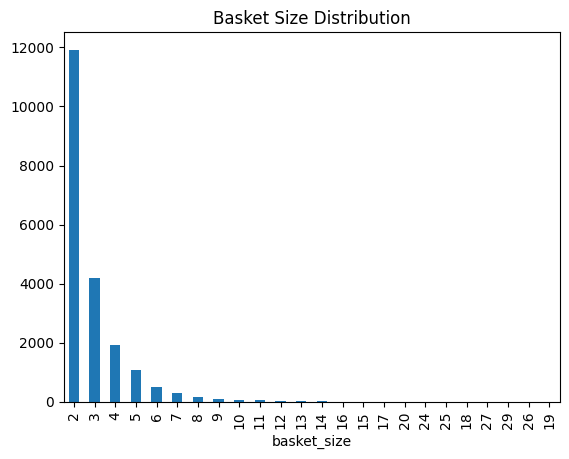

In [35]:
# Distribution of basket sizes
transaction_df["basket_size"].value_counts().sort_values(ascending=False).plot.bar(
    title="Basket Size Distribution",
)

<Axes: title={'center': 'Transactions over time'}, xlabel='rated_date'>

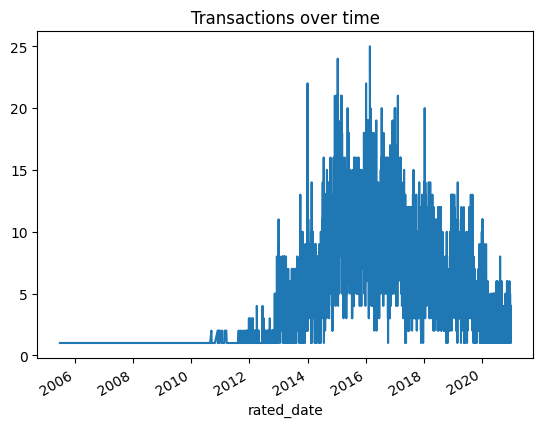

In [36]:
# Transactions over time
transaction_df.groupby("rated_date").size().plot(title="Transactions over time")

## Convert to one-hot encoded format


In [37]:
product_baskets_list = transaction_df["product_basket"].tolist()
product_baskets_list

[['B00M4I1BAY', 'B08QKWQS9J'],
 ['B006GWO5NE', 'B00QL1ZN3G'],
 ['B01FMOGIEK', 'B07WWGYJ8M'],
 ['B00JQTO8TU', 'B016MAOS5E', 'B07193SG3D', 'B0BK6SGHHB', 'B0BN74ZJDK'],
 ['B002DPUUL4', 'B09TWVB2TH'],
 ['B00007M1TZ', 'B002Y6CJJ8', 'B003ZX8B2S'],
 ['B00JO6RO8C', 'B01AOODE18'],
 ['B00IVPU786', 'B00Y20UI1K'],
 ['B0032HM6HS', 'B01G8JO5F2'],
 ['B007TISRBK', 'B008RV51EE', 'B083TH1B45'],
 ['B00OQVZDJM', 'B098DXZN3V'],
 ['B00O1RTQJE', 'B072M34RQC', 'B0BN74ZJDK'],
 ['B01LWX4JJH', 'B01LX4CG4N', 'B08X9HYPZJ', 'B09315SB39'],
 ['B005HS4RF4', 'B0B4QS4F25'],
 ['B002J9HBIO', 'B00E9W1ULS', 'B00M7T8T1E', 'B00UAKWFB2', 'B098DSFTQM'],
 ['B00C631EYU', 'B09TC1K4GY'],
 ['B013ALA9LA', 'B0C1J8RZ46'],
 ['B00KQQHFVK', 'B01LW71IBJ'],
 ['B00006B8K2', 'B000MXWSWI', 'B00KAI3KW2', 'B0BB6RBYJ6'],
 ['B00FPAVUHC', 'B083TH1B45'],
 ['B00SFSU53G', 'B01MQWUXZS', 'B075X8471B', 'B07JZT6YMB'],
 ['B01MV2YGRR', 'B0BR6ZF28J'],
 ['B0086YC6JU', 'B0BSFT117F'],
 ['B003ES5ZSW', 'B0067HY7HW'],
 ['B009LGLEFY', 'B00BPO9HOA', 'B00CPJHGTM'],
 

In [38]:
# Encoding the transactions
te = TransactionEncoder()
encoded_transaction_df = pd.DataFrame(
    te.fit(product_baskets_list).transform(product_baskets_list),
    columns=te.columns_,
)

In [39]:
encoded_transaction_df

,0972683275,1449410243,B000001OM5,B00000K2YR,B00002EQCW,B00004TBLW,B00004THD0,B00004WCGF,B00004Z5D1,B00004Z5M1,...,B0CCD3VDQN,B0CCDMQZM7,B0CCQHH8Z6,B0CCSMFH13,B0CD2GYCTB,B0CD3TKTQG,B0CDCN4S5F,B0CDLVKXF7,B0CDVW2RNG,B0CGZ1XLPX
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20415,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20416,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20417,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## FP-Growth Algorithm


In [40]:
min_support = 0.0002

print(
    f"Choose proportion of transactions containing the itemset (min_support) = {min_support}, which is around {min_support * len(encoded_transaction_df):.0f} transactions",
)

Choose proportion of transactions containing the itemset (min_support) = 0.0002, which is around 4 transactions


In [41]:
freq_itemsets = fpgrowth(
    encoded_transaction_df,
    min_support=min_support,
    use_colnames=True,
)

In [42]:
freq_itemsets

,support,itemsets
0,0.000490,(B00M4I1BAY)
1,0.000343,(B08QKWQS9J)
2,0.002106,(B006GWO5NE)
3,0.000882,(B00QL1ZN3G)
4,0.000441,(B01FMOGIEK)
...,...,...
4016,0.000245,"(B010BWYDYA, B08KZ1TZYB, B012SXB6WW)"
4017,0.000588,"(B012SXFW72, B010BWYDYA)"
4018,0.000245,"(B012SXFW72, B013I3HIU0)"
4019,0.000343,"(B007OZNUCE, B007T356BO)"


In [43]:
freq_itemsets["length"] = freq_itemsets["itemsets"].apply(lambda x: len(x))
freq_itemsets.sort_values(by="length", ascending=False).head(10)

,support,itemsets,length
3872,0.000294,"(B01K8B8YA8, B075X8471B, B07456BG8N)",3
4016,0.000245,"(B010BWYDYA, B08KZ1TZYB, B012SXB6WW)",3
3813,0.000245,"(B00CD4221G, B01I4TE612, B00XIVH2LI)",3
3792,0.000245,"(B08KZ1TZYB, B010BWYDYA, B013I3HIU0)",3
3950,0.000294,"(B01MTF2Z37, B075LX7S6B, B075NWYMRY)",3
3995,0.000343,"(B07DNSZPXG, B07DQF8LHL, B07DNZZCPX)",3
3837,0.000294,"(B07P9V8GSH, B008J0Z9TA)",2
3839,0.000245,"(B008J0Z9TA, B0BSF17PM2)",2
3840,0.000441,"(B08SCF2HC2, B0BQLQHP74)",2
3841,0.000294,"(B0BS2ZMHCL, B0BQLQHP74)",2


In [44]:
freq_itemsets["length"].value_counts().sort_index()

length
1    3748
2     267
3       6
Name: count, dtype: int64

<Axes: title={'center': 'Frequent Itemsets Length Distribution'}, xlabel='length'>

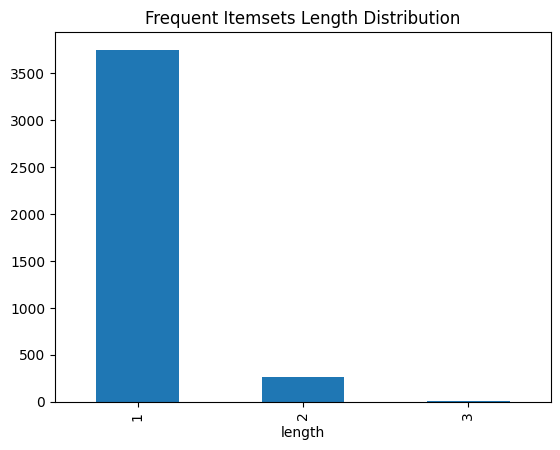

In [45]:
freq_itemsets["length"].value_counts().sort_index().plot.bar(
    title="Frequent Itemsets Length Distribution",
)

In [46]:
# Rules generation
rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.01)
len(rules)

570

In [47]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(B006GWO5NE),(B006GWO5WK),0.002106,0.002987,0.000588,0.279070,93.415173,1.0,0.000581,1.382953,0.991383,0.130435,0.276910,0.237896
1,(B006GWO5WK),(B006GWO5NE),0.002987,0.002106,0.000588,0.196721,93.415173,1.0,0.000581,1.242276,0.992259,0.130435,0.195026,0.237896
2,(B00QL1ZN3G),(B00OQVZDJM),0.000882,0.003526,0.000392,0.444444,126.043210,1.0,0.000389,1.793653,0.992942,0.097561,0.442479,0.277778
3,(B00OQVZDJM),(B00QL1ZN3G),0.003526,0.000882,0.000392,0.111111,126.043210,1.0,0.000389,1.124008,0.995577,0.097561,0.110327,0.277778
4,(B00QL1ZN3G),(B007T356BO),0.000882,0.004016,0.000392,0.444444,110.672087,1.0,0.000388,1.792771,0.991839,0.086957,0.442204,0.271003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,(B013I3HIU0),(B012SXFW72),0.001028,0.000931,0.000245,0.238095,255.877193,1.0,0.000244,1.311279,0.997117,0.142857,0.237386,0.250627
566,(B007OZNUCE),(B007T356BO),0.000539,0.004016,0.000343,0.636364,158.462306,1.0,0.000341,2.738956,0.994225,0.081395,0.634897,0.360865
567,(B007T356BO),(B007OZNUCE),0.004016,0.000539,0.000343,0.085366,158.462306,1.0,0.000341,1.092744,0.997696,0.081395,0.084873,0.360865
568,(B0017U0WM8),(B00WUI2L5M),0.000637,0.001812,0.000245,0.384615,212.255717,1.0,0.000244,1.622055,0.995923,0.111111,0.383498,0.259875


In [48]:
print(f"Length of rules: {len(rules)}")
print(f"Avg confidence: {rules['confidence'].mean():.4f}")

Length of rules: 570
Avg confidence: 0.1865


## Recommendation logic


In [49]:
MAX_ANTECEDENT_ITEMS = 2
recommendations = defaultdict(list)

for _, row in tqdm(rules.iterrows()):
    # Do not consider rules with more than 2 items in the antecedent
    if len(row["antecedents"]) >= MAX_ANTECEDENT_ITEMS:
        continue

    # Get metrics of recommendation
    support = row["support"]
    confidence = row["confidence"]
    lift = row["lift"]

    # Get current itemset
    itemset = ", ".join(list(row["antecedents"]))
    rec_itemset = list(row["consequents"])
    recommendations[itemset].append(
        {
            "support": support,
            "confidence": confidence,
            "lift": lift,
            "recommendation": rec_itemset,
        },
    )

570it [00:00, 28527.23it/s]


In [50]:
recommendations

defaultdict(list,
            {'B006GWO5NE': [{'support': 0.0005876879377050786,
               'confidence': 0.27906976744186046,
               'lift': 93.41517346549752,
               'recommendation': ['B006GWO5WK']},
              {'support': 0.00024486997404378274,
               'confidence': 0.11627906976744186,
               'lift': 296.78779069767444,
               'recommendation': ['B00QFQRELG']}],
             'B006GWO5WK': [{'support': 0.0005876879377050786,
               'confidence': 0.1967213114754098,
               'lift': 93.41517346549752,
               'recommendation': ['B006GWO5NE']},
              {'support': 0.00024486997404378274,
               'confidence': 0.08196721311475409,
               'lift': 98.45226615236258,
               'recommendation': ['B0083Q04IQ']},
              {'support': 0.00024486997404378274,
               'confidence': 0.08196721311475409,
               'lift': 152.15350223546946,
               'recommendation': ['B008GFRE5

In [51]:
# Calculate fallback recommendations: popular items
popular_df = ratings_df.pipe(
    lambda df: df.groupby("product_asin", as_index=False)
    .size()
    .sort_values(by="size", ascending=False)
    .head(100),
).pipe(lambda df: df.assign(prob=df["size"] / df["size"].sum()))

In [52]:
popular_df

,product_asin,size,prob
2694,B01K8B8YA8,934,0.043992
3089,B075X8471B,862,0.040601
2237,B010BWYDYA,597,0.028119
2253,B011BRUOMO,586,0.027601
3678,B07S764D9V,544,0.025623
...,...,...,...
1375,B00EZMZULI,123,0.005793
4692,B0BZ5KPQZK,122,0.005746
3265,B07BX4X77P,122,0.005746
758,B006GWO5WK,122,0.005746


## Dump to DB


In [53]:
fpgrowth_recommendations_df = pd.DataFrame(
    [
        {
            "product_asin": product_asin,
            "recommendations": [
                {
                    "recommendation": r["recommendation"][0],
                    "confidence": r["confidence"],
                }
                for r in recs
            ],
        }
        for product_asin, recs in recommendations.items()
    ],
)

In [54]:
with pd.option_context("display.max_colwidth", None):
    display(fpgrowth_recommendations_df.head(10))

,product_asin,recommendations
0,B006GWO5NE,"[{'recommendation': 'B006GWO5WK', 'confidence': 0.27906976744186046}, {'recommendation': 'B00QFQRELG', 'confidence': 0.11627906976744186}]"
1,B006GWO5WK,"[{'recommendation': 'B006GWO5NE', 'confidence': 0.1967213114754098}, {'recommendation': 'B0083Q04IQ', 'confidence': 0.08196721311475409}, {'recommendation': 'B008GFRE5A', 'confidence': 0.08196721311475409}, {'recommendation': 'B008SYWFNA', 'confidence': 0.08196721311475409}]"
2,B00QL1ZN3G,"[{'recommendation': 'B00OQVZDJM', 'confidence': 0.4444444444444445}, {'recommendation': 'B007T356BO', 'confidence': 0.4444444444444445}]"
3,B00OQVZDJM,"[{'recommendation': 'B00QL1ZN3G', 'confidence': 0.11111111111111112}, {'recommendation': 'B007T356BO', 'confidence': 0.2361111111111111}, {'recommendation': 'B01J2G4VBG', 'confidence': 0.06944444444444445}, {'recommendation': 'B07BSVLHYD', 'confidence': 0.06944444444444445}]"
4,B007T356BO,"[{'recommendation': 'B00QL1ZN3G', 'confidence': 0.0975609756097561}, {'recommendation': 'B00OQVZDJM', 'confidence': 0.20731707317073172}, {'recommendation': 'B007OZNZG0', 'confidence': 0.0975609756097561}, {'recommendation': 'B00BGIQS1A', 'confidence': 0.10975609756097561}, {'recommendation': 'B007OZNUCE', 'confidence': 0.08536585365853659}]"
5,B0BN74ZJDK,"[{'recommendation': 'B0BGNG1294', 'confidence': 0.0390625}, {'recommendation': 'B00EZMZULI', 'confidence': 0.0390625}]"
6,B0BGNG1294,"[{'recommendation': 'B0BN74ZJDK', 'confidence': 0.01779359430604982}, {'recommendation': 'B083TH1B45', 'confidence': 0.021352313167259784}, {'recommendation': 'B075X8471B', 'confidence': 0.03202846975088968}, {'recommendation': 'B00U3FPN4U', 'confidence': 0.02491103202846975}, {'recommendation': 'B01N75TWSA', 'confidence': 0.02491103202846975}, {'recommendation': 'B011BRUOMO', 'confidence': 0.028469750889679714}, {'recommendation': 'B015WCV70W', 'confidence': 0.01779359430604982}, {'recommendation': 'B09Q7YPZPJ', 'confidence': 0.01779359430604982}, {'recommendation': 'B00ZVJAF9G', 'confidence': 0.02491103202846975}, {'recommendation': 'B074DXQ5VL', 'confidence': 0.02491103202846975}]"
7,B09TWVB2TH,"[{'recommendation': 'B0BB6Y5N3M', 'confidence': 0.04807692307692307}]"
8,B0BB6Y5N3M,"[{'recommendation': 'B09TWVB2TH', 'confidence': 0.043103448275862065}]"
9,B003ZX8B2S,"[{'recommendation': 'B01I4TE612', 'confidence': 0.3571428571428571}]"


In [55]:
# # Apply json.dumps to the recommendations column
# fpgrowth_recommendations_df["recommendations"] = fpgrowth_recommendations_df[
#     "recommendations"
# ].apply(json.dumps)

In [56]:
fpgrowth_recommendations_df.to_sql(
    "fpgrowth_product_recommendations",
    conn,
    if_exists="replace",
    index=False,
    dtype={
        "product_asin": sqlalchemy.Text(),
        "recommendations": sqlalchemy.dialects.postgresql.JSONB,
    },
)

257